# ABP extraction
Extraction of systolic, diastolic and mean arterial blood pressure values

There are two potential approaches:
1. Obtaining BPs directly from the numerics:
   - This has the advantage that no signal processing is required
   - But the disadvantage that it does require reading additional numerics files (although perhaps it would be helpful to provide an example of this anyway).
2. Obtaining BPs from the ABP signal
   - This has the advantage that the BP signal data are already in the waveform files containing PPG signals.
   - But it would require signal processing. At a minimum, it would require detecting the maximum and minimum values of the BP signal in a given period (to give SBP and DBP), and potentially the signal processing could be much more complex, _e.g._ BP beat detection, signal quality assessment, detection of systolic peaks and diastolic troughs.

In [2]:
# setup
import sys
import numpy as np
import scipy.signal as sp

from matplotlib import pyplot as plt

import wfdb

# Download records
Identify and download records in the MIMIC III Waveform Database

Selected record: 3000063_0013
10 seconds of data loaded from: 3000063_0013


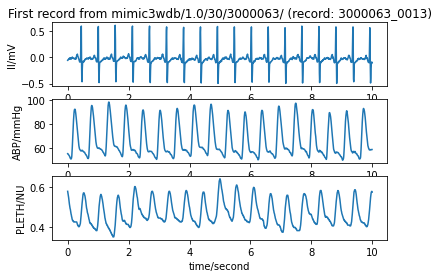

In [3]:
# Select the first record
selected_record = '3000063_0013'
database_name = 'mimic3wdb/1.0/30/3000063/'
print("Selected record: {}".format(selected_record))

# load data from this record
start_seconds = 20
no_seconds_to_load = 10
fs = 125
record_data = wfdb.rdrecord(record_name = selected_record, sampfrom = fs*start_seconds, sampto = fs*(start_seconds + no_seconds_to_load), pn_dir = database_name) 
print("{} seconds of data loaded from: {}".format(no_seconds_to_load, selected_record))

# Plot the data loaded from this record
title_text = "First record from " + database_name + " (record: " + selected_record + ")"
wfdb.plot_wfdb(record=record_data, title=title_text, time_units='seconds') 

# Separate records
Separate ECG, PPG and ABP signals

ECG at position 0
ABP at position 1
PPG at position 2


[Text(0.5, 0, 'Time [s]'), Text(0, 0.5, 'ABP')]

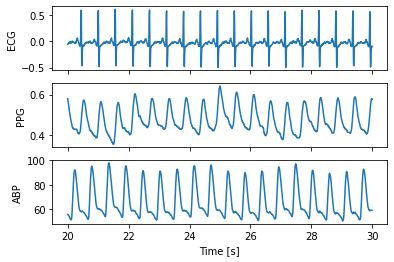

In [4]:
# ECG, PPG and ABP extraction
h = 0
for i in record_data.sig_name:
    if i == 'II':
        print('ECG at position ' + str(h))
        ecg = record_data.p_signal[:,h]
    elif i == 'PLETH':
        print('PPG at position ' + str(h))
        ppg = record_data.p_signal[:,h]
    elif i == 'ABP':
        print('ABP at position ' + str(h))
        abp = record_data.p_signal[:,h]
    else:
        print('Other signal (' + i + ') at position ' + str(h))
    h = h + 1

t = np.arange(start_seconds,(start_seconds + no_seconds_to_load),1.0/fs)

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex = True, sharey = False)
ax1.plot(t, ecg)
ax1.set(xlabel = '', ylabel = 'ECG')
ax2.plot(t, ppg)
ax2.set(xlabel = '', ylabel = 'PPG')
ax3.plot(t, abp)
ax3.set(xlabel = 'Time [s]', ylabel = 'ABP')

In [5]:
# Remove NaNs
x, = np.where(np.isnan(ecg))
if len(x) != 0:
    print('NaNs in ECG: ' + str(x))
    for i in x:
        ecg[i] = ecg[i - 1]
x, = np.where(np.isnan(ppg))
if len(x) != 0:
    print('NaNs in PPG: ' + str(x))
    for i in x:
        ppg[i] = ppg[i - 1]
x, = np.where(np.isnan(abp))
if len(x) != 0:
    print('NaNs in ABP: ' + str(x))
    for i in x:
        abp[i] = abp[i - 1]

# Filter data

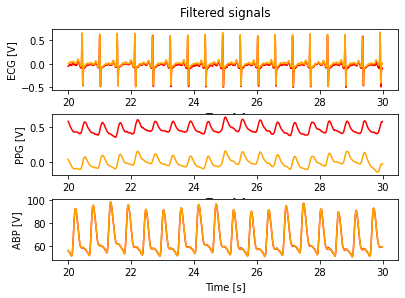

In [6]:
# Filter ECG
sos_ecg = sp.butter(10, [0.5, 40], btype = 'bp', analog = False, output = 'sos', fs = fs)
ecg_ff = sp.sosfiltfilt(sos_ecg, ecg)

# Filter PPG
sos_ppg = sp.butter(10, [0.2, 10], btype = 'bp', analog = False, output = 'sos', fs = fs)
ppg_ff = sp.sosfiltfilt(sos_ppg, ppg)

# Filter ABP
sos_abp = sp.butter(10, 10, btype = 'low', analog = False, output = 'sos', fs = fs)
abp_ff = sp.sosfiltfilt(sos_abp, abp)

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex = False, sharey = False)
fig.suptitle('Filtered signals') 

ax1.plot(t, ecg, color = 'red')
ax1.plot(t, ecg_ff, color = 'orange')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('ECG [V]')

ax2.plot(t, ppg, color = 'red')
ax2.plot(t, ppg_ff, color = 'orange')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('PPG [V]')

ax3.plot(t, abp, color = 'red')
ax3.plot(t, abp_ff, color = 'orange')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('ABP [V]')

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.4, 
                    hspace = 0.4)

#plt.show()

# ABP values extraction
Peaks and onsets detection from ABP signals

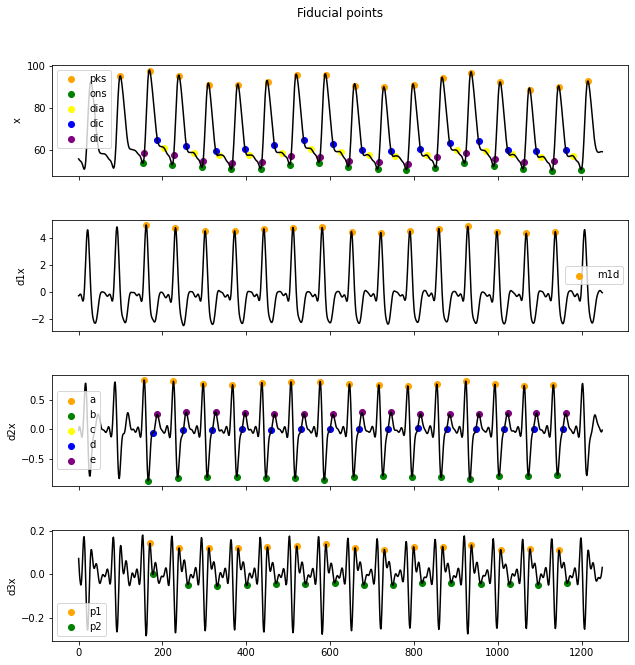

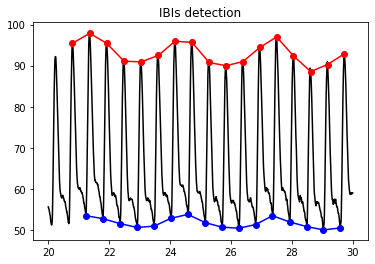

In [18]:
%run pulse_processing.ipynb
ibis = pulse_detect(abp_ff,fs,5,'delineator')
fidp = fiducial_points(abp_ff,ibis,fs,vis = True)

fig = plt.figure()
plt.title('IBIs detection') 
plt.plot(t, abp, color = 'black')
plt.plot(t[0] + fidp['pks']/fs, abp_ff[fidp['pks']], color = 'red', marker = 'o')
plt.plot(t[0] + fidp['ons']/fs, abp_ff[fidp['ons']], color = 'blue', marker = 'o')

Assessment of blood pressure magnitudes

In [9]:
abp_sbp = np.mean(abp[fidp['pks']])
abp_dbp = np.mean(abp[fidp['ons']])
abp_map = (1/3)*abp_sbp + (2/3)*abp_dbp

print('Systolic blood pressure: ' + str(abp_sbp) + '\n' + 
      'Diastolic blood pressure:' + str(abp_dbp) + '\n' +  
      'Mean arterial pressure:' + str(abp_map))

Systolic blood pressure: 92.86764705882354
Diastolic blood pressure:52.24609375
Mean arterial pressure:65.78661151960785
